In [2]:
import os
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, matthews_corrcoef, mean_squared_error

In [2]:
def scale_features(data_dict):
    """
    Scales the data in a dictionary using StandardScaler.
    
    Parameters:
        data_dict (dict): Dictionary where each key is a subject, and the value is a 2D array 
                          (samples x features).
                          
    Returns:
        dict: A new dictionary with scaled data, maintaining the same structure as the input.
    """
    # Combine all data into a single array
    all_samples = np.vstack(list(data_dict.values()))  # Shape: (total_samples, num_features)

    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(all_samples)  # Shape: (total_samples, num_features)

    # Split scaled data back into original structure
    split_indices = np.cumsum([len(samples) for samples in data_dict.values()])[:-1]
    scaled_subjects = np.split(scaled_data, split_indices)

    # Reconstruct the dictionary with scaled data
    scaled_data_dict = {key: scaled_subjects[i] for i, key in enumerate(data_dict.keys())}

    return scaled_data_dict

In [3]:
features = "pca_mfcc_20_no_pitch_1000_rand_all_speakers"

with open(f"../../data/extracted_features_v2/{features}.pickle", "rb") as file:
   mfcc_stats_dict = pickle.load(file)

if "pca" not in features:
   print("scaling performed")
   mfcc_stats_dict = scale_features(mfcc_stats_dict)

for reader in mfcc_stats_dict.keys():
    print(f"reader: {reader} | # samples {len(mfcc_stats_dict[reader])}")

reader: 103 | # samples 1000
reader: 1034 | # samples 1000
reader: 1069 | # samples 1000
reader: 1081 | # samples 1000
reader: 1088 | # samples 1000
reader: 1098 | # samples 1000
reader: 1116 | # samples 1000
reader: 118 | # samples 1000
reader: 1235 | # samples 1000
reader: 1246 | # samples 1000
reader: 125 | # samples 1000
reader: 1263 | # samples 1000
reader: 1334 | # samples 1000
reader: 1355 | # samples 1000
reader: 1363 | # samples 1000
reader: 1447 | # samples 1000
reader: 1455 | # samples 1000
reader: 150 | # samples 1000
reader: 1502 | # samples 1000
reader: 1553 | # samples 1000
reader: 1578 | # samples 1000
reader: 1594 | # samples 1000
reader: 1624 | # samples 1000
reader: 163 | # samples 1000
reader: 1723 | # samples 1000
reader: 1737 | # samples 1000
reader: 1743 | # samples 1000
reader: 1841 | # samples 1000
reader: 1867 | # samples 1000
reader: 1898 | # samples 1000
reader: 19 | # samples 1000
reader: 1926 | # samples 1000
reader: 196 | # samples 1000
reader: 1963 | # s

In [1]:
def partition_data(reader, max, split=.8):
    mfccs = [mfcc for mfcc in reader]
    mfccs = mfccs[0:max]

    mfccs_train = mfccs[0:round(len(mfccs)*split)]
    mfccs_test  = mfccs[round(len(mfccs)*split):len(mfccs)]

    return mfccs_train, mfccs_test

def partition_wrapper(data_dictionary, max):
    test_dict = {}
    train_dict = {}

    for key in data_dictionary.keys():
        train, test = partition_data(data_dictionary[key], max)
        train_dict[key] = train
        test_dict[key] = test

    return train_dict, test_dict

In [3]:
def generate_random_indices(n, x, seed=42):
    if n > x + 1:
        raise ValueError("Cannot generate more unique numbers than the specified range.")
    
    random.seed(seed)  # Set the seed for reproducibility
    return random.sample(range(0, x), n)

def average_score(model,test_data):
    scores = []
    for data_point in test_data:
        scores.append(model.score(data_point.reshape(1,-1)))
    return scores, np.mean(scores)

def average_score_compare(model_dict, test_data_dict):
    for model_key in model_dict.keys():
        score_list = []
        for data_key in test_data_dict.keys():
            _, avg_score = average_score(model_dict[model_key], test_data_dict[data_key])
            avg_score = round(float(avg_score), 3)
            score_list.append((data_key, avg_score))
        print(f"model {model_key}: {score_list}")

def generate_binary_test_set(data_dict, key):
    if key not in data_dict:
        raise KeyError(f"The key '{key}' does not exist in the dictionary.")
    
    true_values = data_dict[key] # Get the list corresponding to the key

    num_other_classes = len(data_dict.keys()) - 1
    num_of_true_samples = len(true_values)

    samples_per_class = num_of_true_samples // num_other_classes
    # print(f"samples per class: {samples_per_class}")

    random_indices = generate_random_indices(samples_per_class, num_of_true_samples)

    test_set = true_values.copy()  # Start with the list for the specified key
    
    if isinstance(test_set, np.ndarray):
        test_set = test_set.tolist()

    for k, v in data_dict.items():
        if k != key:  # Skip the list that corresponds to the key
            for i in random_indices:
                test_set.append(v[i])

    return test_set, num_of_true_samples

def generate_metrics(model_dict, data_dict, key):
   """
   Returns metrics for One-Class SVM using predict():
   - [TP, FP
      FN, TN].
   """
   
   model = model_dict[key]
   
   # Concatenate data (assuming the data_dict is structured similarly to the original code)
   data, segments_length = generate_binary_test_set(data_dict, key)

   # Ground truth: first part is non-target (0), second part is target (1)
   ground_truth = [0] * segments_length + [1] * (len(data) - segments_length)
   
   # Get binary predictions (1 for inliers, -1 for outliers)
   predicted_labels = model.predict(data)

   # Convert predictions to binary labels: 1 for inliers, 0 for outliers
   predicted_labels = [1 if label == 1 else 0 for label in predicted_labels]

   # Generate confusion matrix and other metrics
   matrix = confusion_matrix(ground_truth, predicted_labels)
   accuracy = accuracy_score(ground_truth, predicted_labels)
   precision = precision_score(ground_truth, predicted_labels)
   recall = recall_score(ground_truth, predicted_labels)
   f1 = f1_score(ground_truth, predicted_labels)
   
   # For ROC AUC, we use the decision function to get the scores
   decision_scores = model.decision_function(data)
   roc_auc = roc_auc_score(ground_truth, decision_scores)
   fpr, tpr, _ = roc_curve(ground_truth, decision_scores)
   
   return matrix, accuracy, precision, recall, f1, roc_auc, fpr, tpr

def save_metrics(model_dict, data_dict, output_file="./metrics.txt"):
    metric_dict = {}
    
    for key in model_dict.keys():
        # threshold, matrix, accuracy, precision, recall, f1, roc_auc, _, _ = generate_metrics(model_dict, data_dict, key)
        matrix, accuracy, precision, recall, f1, roc_auc, _, _ = generate_metrics(model_dict, data_dict, key)

        if isinstance(matrix, np.ndarray):
            matrix = matrix.tolist()

        metric_dict[key] = {
            'matrix': matrix,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }
        
    accuracies = [metrics['accuracy'] for metrics in metric_dict.values()]
    precisions = [metrics['precision'] for metrics in metric_dict.values()]
    recalls = [metrics['recall'] for metrics in metric_dict.values()]
    f1_scores = [metrics['f1'] for metrics in metric_dict.values()]
    roc_aucs = [metrics['roc_auc'] for metrics in metric_dict.values()]

    def five_num_summary(values):
        return {
            'min': np.min(values),
            'q1': np.percentile(values, 25),
            'median': np.median(values),
            'q3': np.percentile(values, 75),
            'max': np.max(values),
            'mean': np.mean(values)
        }
    
    accuracy_summary = five_num_summary(accuracies)
    precision_summary = five_num_summary(precisions)
    recall_summary = five_num_summary(recalls)
    f1_summary = five_num_summary(f1_scores)
    roc_auc_summary = five_num_summary(roc_aucs)

    with open(output_file, 'w') as f:
        f.write(f"summary: \n")
        f.write(f"    five num sum accuracy : {accuracy_summary['min']:.4f} | {accuracy_summary['q1']:.4f} | {accuracy_summary['median']:.4f} | {accuracy_summary['q3']:.4f} | {accuracy_summary['max']:.4f} | mean: {accuracy_summary['mean']:.4f}\n")
        f.write(f"    five num sum precision: {precision_summary['min']:.4f} | {precision_summary['q1']:.4f} | {precision_summary['median']:.4f} | {precision_summary['q3']:.4f} | {precision_summary['max']:.4f} | mean: {precision_summary['mean']:.4f}\n")
        f.write(f"    five num sum recall   : {recall_summary['min']:.4f} | {recall_summary['q1']:.4f} | {recall_summary['median']:.4f} | {recall_summary['q3']:.4f} | {recall_summary['max']:.4f} | mean: {recall_summary['mean']:.4f}\n")
        f.write(f"    five num sum F1-score : {f1_summary['min']:.4f} | {f1_summary['q1']:.4f} | {f1_summary['median']:.4f} | {f1_summary['q3']:.4f} | {f1_summary['max']:.4f} | mean: {f1_summary['mean']:.4f}\n")
        f.write(f"    five num sum ROC AUC  : {roc_auc_summary['min']:.4f} | {roc_auc_summary['q1']:.4f} | {roc_auc_summary['median']:.4f} | {roc_auc_summary['q3']:.4f} | {roc_auc_summary['max']:.4f} | mean: {roc_auc_summary['mean']:.4f}\n")
        f.write("\n")

        for key, metrics in metric_dict.items():
            f.write(f"{key}:\n")
            f.write(f"    accuracy: {metrics['accuracy']:.4f}\n")
            f.write(f"    precision: {metrics['precision']:.4f}\n")
            f.write(f"    recall: {metrics['recall']:.4f}\n")
            f.write(f"    F1-score: {metrics['f1']:.4f}\n")
            f.write(f"    ROC AUC: {metrics['roc_auc']:.4f}\n")
            
            # Formatting the matrix
            f.write(f"    matrix:\n")
            for row in metrics['matrix']:
                f.write(f"        {row}\n")
        f.write("\n")

    return metric_dict

def plot_roc_all(model_dict, data_dict, features_used="", save_dir=None):
    plt.figure(figsize=(13, 11))

    for key in model_dict.keys():
        _, _, _, _, _, roc_auc, fpr, tpr, = generate_metrics(model_dict, data_dict, key)
        plt.plot(fpr, tpr, label=f'{key} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for All Models {features_used}')
    plt.legend(loc="lower right")

    if save_dir:    
        plt.savefig(os.path.join(save_dir, f"{features_used}.png"))
    plt.show()
    plt.close()

In [6]:
def train_svm(train_dict, key):
    training_data, segments_length = generate_binary_test_set(train_dict, key)
    training_data = np.vstack(training_data)
    ground_truth = [0] * segments_length + [1] * (len(training_data) - segments_length)
    model = SVC(kernel='rbf', C=1.0, gamma='scale')
    return(model.fit(training_data, ground_truth))

def train_wrapper(train_dict):
    model_dict = {}

    for key in train_dict.keys():
        model_dict[key] = train_svm(train_dict, key)
    
    return(model_dict)

In [8]:
train_data, test_data = partition_wrapper(mfcc_stats_dict, 1000)
speaker_models = train_wrapper(train_data)

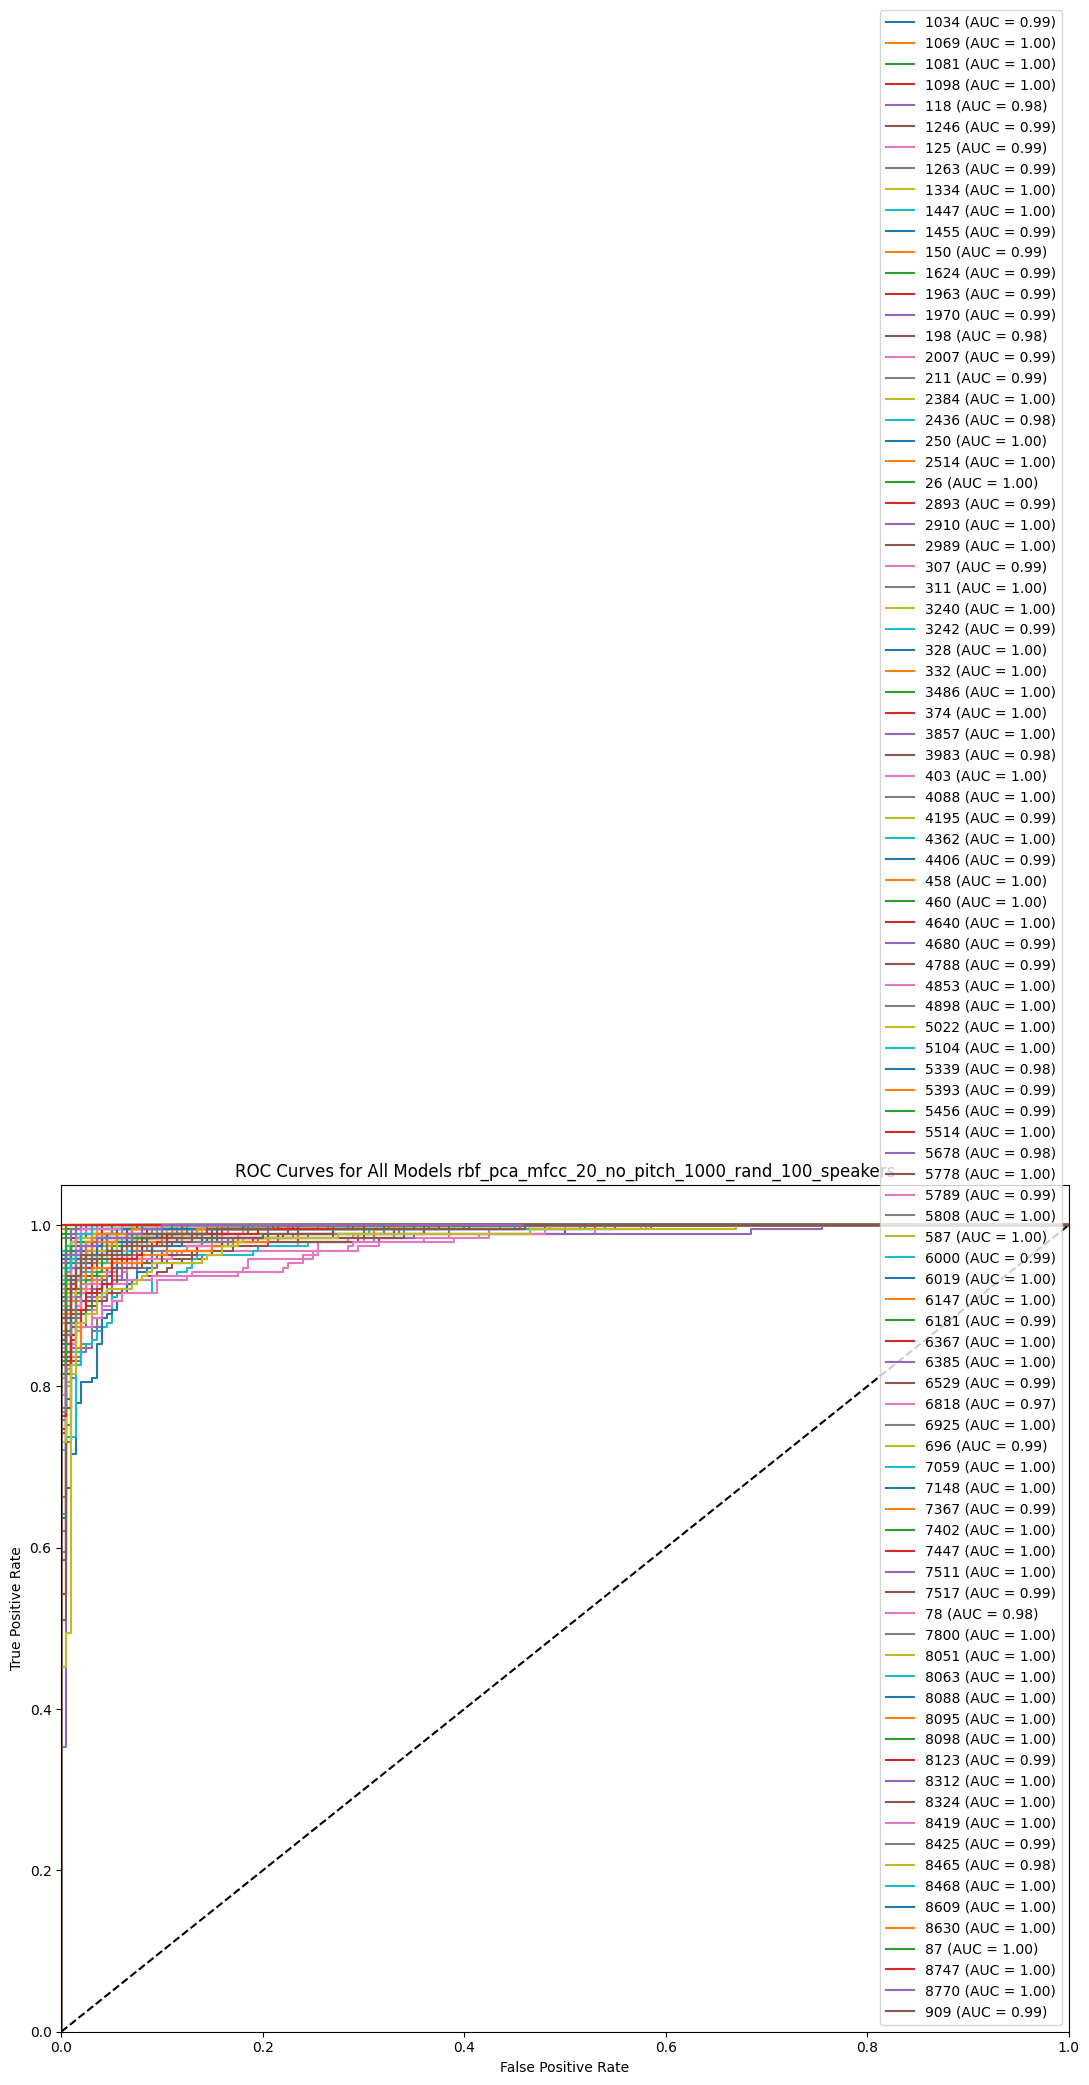

In [9]:
save_metrics(speaker_models, test_data, output_file=f"./metrics/SVM/rbf_{features}.txt")
plot_roc_all(speaker_models, test_data, features_used=f"rbf_{features}", save_dir="./metrics/SVM/plots")

### K-Fold Modifications

In [4]:
def calculate_roc_auc(metric_dict):
    roc_auc_list = []
    for speaker in metric_dict.keys():
        fpr = metric_dict[speaker]["best_model"]['fpr']
        tpr = metric_dict[speaker]["best_model"]['tpr']
        roc_auc_list.append(np.trapezoid(tpr, fpr))
    
    return roc_auc_list

def save_metrics_kfold(metric_dict, output_file=f"./metrics"):

    accuracies = [metrics['accuracy'] for metrics in metric_dict.values()]
    precisions = [metrics['precision'] for metrics in metric_dict.values()]
    recalls = [metrics['recall'] for metrics in metric_dict.values()]
    f1_scores = [metrics['f1'] for metrics in metric_dict.values()]
    roc_aucs = calculate_roc_auc(metric_dict)
    mse = [metrics['mse'] for metrics in metric_dict.values()]
    eers = [metrics['eer'] for metrics in metric_dict.values()]
    mcc = [metrics['mcc'] for metrics in metric_dict.values()]

    def five_num_summary(values):
        return {
            'min': np.min(values),
            'q1': np.percentile(values, 25),
            'median': np.median(values),
            'q3': np.percentile(values, 75),
            'max': np.max(values),
            'mean': np.mean(values)
        }
    
    accuracy_summary = five_num_summary(accuracies)
    precision_summary = five_num_summary(precisions)
    recall_summary = five_num_summary(recalls)
    f1_summary = five_num_summary(f1_scores)
    mse_summary = five_num_summary(mse)
    roc_auc_summary = five_num_summary(roc_aucs)
    eer_summary = five_num_summary(eers)  
    mcc_summary = five_num_summary(mcc)  

    with open(output_file, 'w') as f:
        f.write(f"summary: \n")
        f.write(f"    five num sum accuracy : {accuracy_summary['min']:.4f} | {accuracy_summary['q1']:.4f} | {accuracy_summary['median']:.4f} | {accuracy_summary['q3']:.4f} | {accuracy_summary['max']:.4f} | mean: {accuracy_summary['mean']:.4f}\n")
        f.write(f"    five num sum precision: {precision_summary['min']:.4f} | {precision_summary['q1']:.4f} | {precision_summary['median']:.4f} | {precision_summary['q3']:.4f} | {precision_summary['max']:.4f} | mean: {precision_summary['mean']:.4f}\n")
        f.write(f"    five num sum recall   : {recall_summary['min']:.4f} | {recall_summary['q1']:.4f} | {recall_summary['median']:.4f} | {recall_summary['q3']:.4f} | {recall_summary['max']:.4f} | mean: {recall_summary['mean']:.4f}\n")
        f.write(f"    five num sum F1-score : {f1_summary['min']:.4f} | {f1_summary['q1']:.4f} | {f1_summary['median']:.4f} | {f1_summary['q3']:.4f} | {f1_summary['max']:.4f} | mean: {f1_summary['mean']:.4f}\n")
        f.write(f"    five num sum ROC AUC  : {roc_auc_summary['min']:.4f} | {roc_auc_summary['q1']:.4f} | {roc_auc_summary['median']:.4f} | {roc_auc_summary['q3']:.4f} | {roc_auc_summary['max']:.4f} | mean: {roc_auc_summary['mean']:.4f}\n")
        f.write(f"    five num sum MSE      : {mse_summary['min']:.4f} | {mse_summary['q1']:.4f} | {mse_summary['median']:.4f} | {mse_summary['q3']:.4f} | {mse_summary['max']:.4f} | mean: {mse_summary['mean']:.4f}\n")
        f.write(f"    five num sum EER      : {eer_summary['min']:.4f} | {eer_summary['q1']:.4f} | {eer_summary['median']:.4f} | {eer_summary['q3']:.4f} | {eer_summary['max']:.4f} | mean: {eer_summary['mean']:.4f}\n")
        f.write(f"    five num sum MCC      : {mcc_summary['min']:.4f} | {mcc_summary['q1']:.4f} | {mcc_summary['median']:.4f} | {mcc_summary['q3']:.4f} | {mcc_summary['max']:.4f} | mean: {mcc_summary['mean']:.4f}\n")
        
        f.write("\n")

        for key, metrics in metric_dict.items():
            f.write(f"{key}:\n")
            f.write(f"    accuracy: {metrics['accuracy']:.4f}\n")
            f.write(f"    precision: {metrics['precision']:.4f}\n")
            f.write(f"    recall: {metrics['recall']:.4f}\n")
            f.write(f"    F1-score: {metrics['f1']:.4f}\n")
            f.write(f"    ROC AUC: {metrics['roc_auc']:.4f}\n")
            f.write(f"    MSE: {metrics['mse']:.4f}\n")
            f.write(f"    EER: {metrics['eer']:.4f}\n")
            f.write(f"    MCC: {metrics['mcc']:.4f}\n")

        f.write("\n")

    return metric_dict

def plot_roc_cross_validation(metrics, save_dir=None):
    """
    Plots the ROC curve for cross-validation results.
    
    Parameters:
        metrics (list): A list of metrics dictionaries from cross-validation.
        save_dir (str): Directory to save the plot.
    """
    plt.figure(figsize=(10, 8))

    for speaker in metrics.keys():
        plt.plot(metrics[speaker]["best_model"]['fpr'], metrics[speaker]["best_model"]['tpr'])

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for SVM Cross-Validation')
    plt.legend(loc="lower right")
    plt.grid()
    
    if save_dir:    
        plt.savefig(save_dir)
    plt.show()
    plt.close()

In [6]:
def svm_cross_validate(data_dict, key, n_folds):
    data, segments_length = generate_binary_test_set(data_dict, key)
    data = np.vstack(data)
    ground_truth = np.array([0] * segments_length + [1] * (len(data) - segments_length))

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    metrics_list = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "roc_auc": [],
        "mse": [],
        "eer": [],
        "mcc": []
    }
    best_model_metrics = {
        "fpr" : None,
        "tpr" : None,
        "roc_auc": 0.0,
        "eer": None,
        "model": None,
    }

    for train_idx, test_idx in kf.split(data):
        data_train, data_test = data[train_idx], data[test_idx]
        label_train, label_test = ground_truth[train_idx], ground_truth[test_idx] 
        model = SVC(kernel='rbf', C=1.0, gamma='scale') # default
        # model = SVC(kernel='linear', C=1.0, gamma='scale') 
        # model = SVC(kernel='poly', degree=3, C=1.0, gamma='scale') 
        # model = SVC(kernel='rbf', C=1.0, gamma='auto') 
        # model = SVC(kernel='sigmoid', C=1.0, gamma='scale') 
        # model = SVC(kernel='rbf', C=0.9, gamma='scale') 
        # model = SVC(kernel='rbf', C=2.5, gamma='auto') 
        #model = SVC(kernel='rbf', C=3, gamma="scale") 

        
        model.fit(data_train, label_train)
        # Make predictions on the test set
        test_pred = model.predict(data_test)
        decision_scores = model.decision_function(data_test)

        # Compute metrics for this fold
        accuracy = accuracy_score(label_test, test_pred)
        precision = precision_score(label_test, test_pred, zero_division=0)
        recall = recall_score(label_test, test_pred, zero_division=0)
        f1 = f1_score(label_test, test_pred, zero_division=0)
        roc_auc = roc_auc_score(label_test, decision_scores) if len(np.unique(label_test)) > 1 else 0.0
        mcc = matthews_corrcoef(label_test, test_pred)
        mse = mean_squared_error(label_test, test_pred)

        # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(label_test, decision_scores)
        
        # Compute EER
        fnr = 1 - tpr  # False Negative Rate
        eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
        eer = fpr[np.nanargmin(np.abs(fnr - fpr))]  # EER is the FPR at the threshold where FNR = FPR

        # Append metrics for averaging later
        metrics_list["accuracy"].append(accuracy)
        metrics_list["precision"].append(precision)
        metrics_list["recall"].append(recall)
        metrics_list["f1"].append(f1)
        metrics_list["roc_auc"].append(roc_auc)
        metrics_list["mse"].append(mse)
        metrics_list["eer"].append(eer)
        metrics_list["mcc"].append(mcc)

        # Update the best model if the current fold has a better ROC AUC score
        if roc_auc > best_model_metrics["roc_auc"]:
            # fpr, tpr, _ = roc_curve(label_test, decision_scores)
            best_model_metrics["fpr"] = fpr
            best_model_metrics["tpr"] = tpr
            best_model_metrics["roc_auc"] = roc_auc
            best_model_metrics["eer"] = eer  # Save EER for the best model
            best_model_metrics["model"] = model  # Save the best SVM model


    # Compute the mean of each metric
    mean_metrics = {
        metric: (np.mean(scores) if metric not in ["fpr", "tpr"] else scores)
        for metric, scores in metrics_list.items()
    }
    mean_metrics["best_model"] = best_model_metrics

    return mean_metrics

def svm_cross_validate_wrapper(data_dict, n_folds=5):
    metric_dict = {}

    for key in data_dict.keys():
        metric_dict[key] = svm_cross_validate(data_dict, key, n_folds)

    return(metric_dict)

In [5]:
def split_dict(data, train_ratio=0.8):
    random.seed(42)
    keys = list(data.keys())
    random.shuffle(keys)  # Shuffle the keys to randomize the split
    split_point = int(len(keys) * train_ratio)
    
    train_keys = keys[:split_point]
    test_keys = keys[split_point:]
    
    train_dict = {key: data[key] for key in train_keys}
    test_dict = {key: data[key] for key in test_keys}
    
    return train_dict, test_dict

In [7]:
def five_num_sum_and_mean(data):
    data = sorted(data)
    
    # Calculate the five-number summary
    minimum = np.min(data)
    q1 = np.percentile(data, 25)
    median = np.median(data)
    q3 = np.percentile(data, 75)
    maximum = np.max(data)
    mean = np.mean(data)
    
    return {
        "Minimum": minimum,
        "Q1": q1,
        "Median": median,
        "Q3": q3,
        "Maximum": maximum,
        "Mean": mean
    }

def test_model(model, test_set):
    
    test_pred = model.predict(test_set)
    label_test = [1] * len(test_set)

    accuracy = accuracy_score(label_test, test_pred)

    return accuracy

def test_model_wrapper(model_dict, test_dict):
    combined_list = [value for sublist in test_dict.values() for value in sublist]

    accuracies = []
    for key in model_dict.keys():
        accuracies.append(test_model(model_dict[key]["best_model"]["model"], combined_list))

    return accuracies


In [8]:
features = "pca_mfcc_20_no_pitch_1000_rand_all_speakers"

with open(f"../../data/extracted_features_v2/{features}.pickle", "rb") as file:
   mfcc_stats_dict = pickle.load(file)

print(len(mfcc_stats_dict.keys()))

for reader in mfcc_stats_dict.keys():
    print(f"reader: {reader} | # samples {len(mfcc_stats_dict[reader])}") 

245
reader: 103 | # samples 1000
reader: 1034 | # samples 1000
reader: 1069 | # samples 1000
reader: 1081 | # samples 1000
reader: 1088 | # samples 1000
reader: 1098 | # samples 1000
reader: 1116 | # samples 1000
reader: 118 | # samples 1000
reader: 1235 | # samples 1000
reader: 1246 | # samples 1000
reader: 125 | # samples 1000
reader: 1263 | # samples 1000
reader: 1334 | # samples 1000
reader: 1355 | # samples 1000
reader: 1363 | # samples 1000
reader: 1447 | # samples 1000
reader: 1455 | # samples 1000
reader: 150 | # samples 1000
reader: 1502 | # samples 1000
reader: 1553 | # samples 1000
reader: 1578 | # samples 1000
reader: 1594 | # samples 1000
reader: 1624 | # samples 1000
reader: 163 | # samples 1000
reader: 1723 | # samples 1000
reader: 1737 | # samples 1000
reader: 1743 | # samples 1000
reader: 1841 | # samples 1000
reader: 1867 | # samples 1000
reader: 1898 | # samples 1000
reader: 19 | # samples 1000
reader: 1926 | # samples 1000
reader: 196 | # samples 1000
reader: 1963 |

In [58]:
metrics = svm_cross_validate_wrapper(mfcc_stats_dict, 5)
save_metrics_kfold(metrics, output_file=f"./metrics/SVM//k-fold_{features}.txt")
# Took 1 minute and 0.5 seconds for pca mfcc 20
# took 56 seconds for pca mfcc 13

{'103': {'accuracy': np.float64(0.9681217235647616),
  'precision': np.float64(0.9759223817118554),
  'recall': np.float64(0.9589637880328731),
  'f1': np.float64(0.9673465157433843),
  'roc_auc': np.float64(0.9949829014813313),
  'mse': np.float64(0.03187827643523846),
  'eer': np.float64(0.03816683938014761),
  'mcc': np.float64(0.9362952395422705),
  'best_model': {'fpr': array([0.        , 0.        , 0.        , 0.0047619 , 0.0047619 ,
          0.02380952, 0.02380952, 0.03333333, 0.03333333, 0.06666667,
          0.06666667, 0.09047619, 0.09047619, 0.1       , 0.1       ,
          1.        ]),
   'tpr': array([0.        , 0.00540541, 0.95675676, 0.95675676, 0.97297297,
          0.97297297, 0.97837838, 0.97837838, 0.98378378, 0.98378378,
          0.98918919, 0.98918919, 0.99459459, 0.99459459, 1.        ,
          1.        ]),
   'roc_auc': np.float64(0.9982239382239383),
   'eer': np.float64(0.023809523809523808),
   'model': SVC(C=3)}},
 '1034': {'accuracy': np.float64(0.9

In [9]:
# THIS IS A SANITY CHECK ON METHODOLOGY
train_dict, test_dict = split_dict(mfcc_stats_dict, train_ratio=0.8)
metrics_and_models = svm_cross_validate_wrapper(train_dict, 5)
accuracies = test_model_wrapper(metrics_and_models, test_dict)
print(five_num_sum_and_mean(accuracies))
save_metrics_kfold(metrics_and_models, output_file=f"./metrics/SVM/train_k-fold_{features}.txt")

KeyboardInterrupt: 

C:\Users\odink\AppData\Local\Temp\ipykernel_16356\1687053781.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


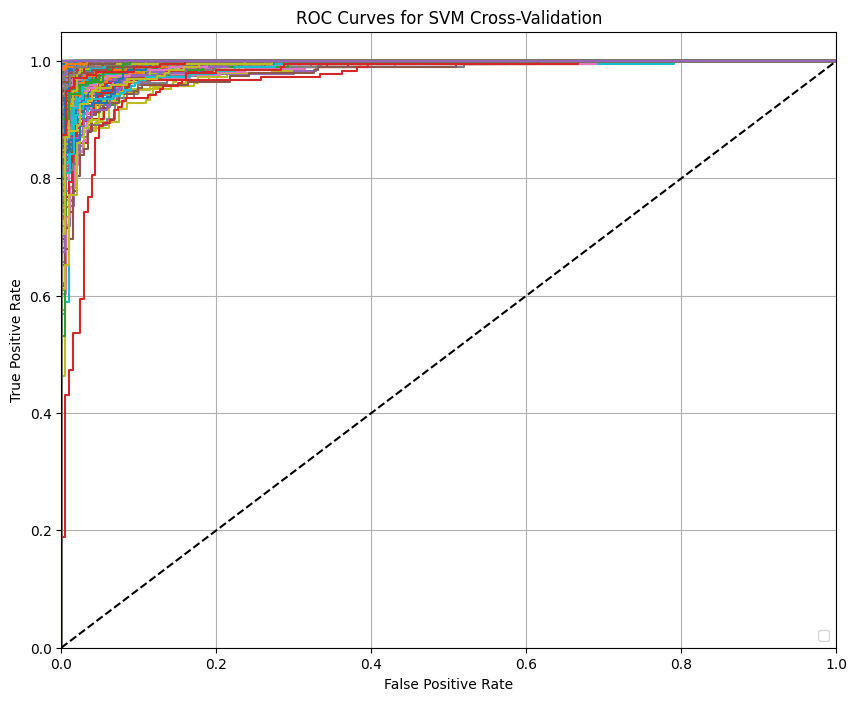

In [12]:
plot_roc_cross_validation(metrics, save_dir=f"./metrics/SVM/plots/k-fold_{features}")